In [1]:
import sys
sys.path.append('../')

from sigmoid import fsigmoid
from classifier_sigmoid import mask_negative_data, get_ewma_derivative
from classifier_sigmoid import get_predicted_flux, get_sigmoid_features_dev
from early_sn_classifier import convert_full_dataset

import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

In [2]:
fname_matrix = '../../../../referee/data/features.csv'

matrix = pd.read_csv(fname_matrix, index_col=False)

In [3]:
Ia_flag = matrix['type'].values == 'Ia'
galaxy_flag = matrix['type'].values == 'AGN'
multiple_obj_flag = matrix['type'].values == 'EB*'
star_flag = matrix['type'].values == 'RRLyr'

In [5]:
ids = [1424192755315015009, 1452439215115010000, 1277247161915010000,
       1385238050715015010]

In [6]:
data_raw = pd.read_csv('../../../../referee/data/raw.csv.gz')
ids_flag = np.array([data_raw['candid'].values[i] in ids for i in range(data_raw.shape[0])])
all_lcs = data_raw[ids_flag]
lcs = convert_full_dataset(all_lcs)

In [22]:
all_lcs[['objectId', 'candid', 'TNS', 'cdsxmatch']]

,objectId,candid,TNS,cdsxmatch
4120,ZTF18aaptrep,1385238050715015010,-99,RRLyr
17110,ZTF18aabtvle,1277247161915010000,-99,EB*
84874,ZTF20acqjmzk,1424192755315015009,SN Ia,-99
86173,ZTF18aarybyq,1452439215115010000,AGN,-99


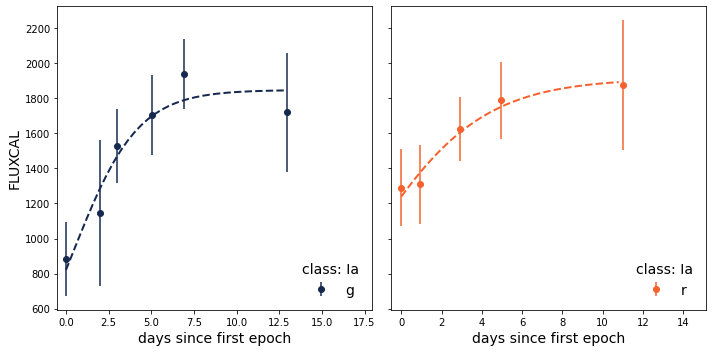

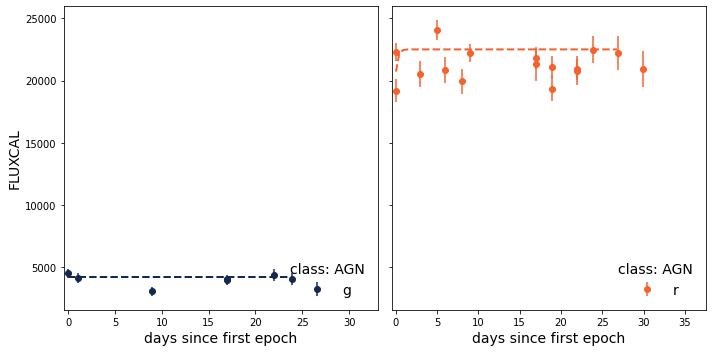

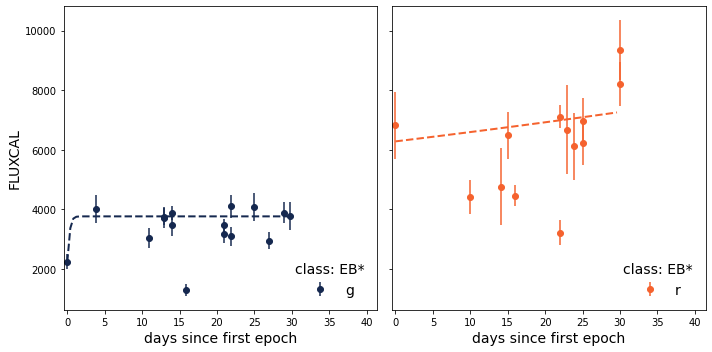

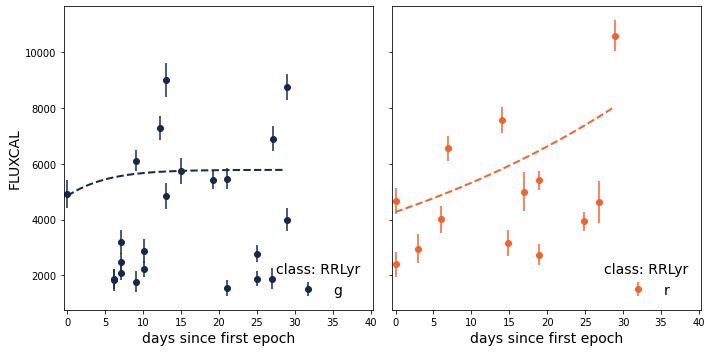

In [17]:
c = ['#15284F', '#F5622E']

filters = list(np.unique(lcs['FLT'].values))

features = []

for name in ids:
    
    ax = {}

    lc_flag = lcs['id'].values == name
    lc_indiv = lcs[lc_flag]

    features_flag = matrix['id'].values == name
    features_indiv = matrix[features_flag]
    features.append(features_indiv)

    plt.figure(figsize=(10,5))

    for f in filters:
        if f == 'r':
            plt.subplot(1,2, filters.index(f) + 1, sharey=ax['g'])
        else:
            plt.subplot(1,2, filters.index(f) + 1)
            
        filter_flag = lc_indiv['FLT'].values == f
        lc_filter = lc_indiv[filter_flag]
    
        # compute the derivative
        deriv_ewma = get_ewma_derivative(lc_filter['FLUXCAL'], 3)
        data_masked = lc_filter.mask(deriv_ewma < 0)
        rising_data = data_masked.dropna()
    
        x = np.arange(0, max(rising_data['MJD']) - min(rising_data['MJD']), 0.4)
    
        y = get_predicted_flux(x, features_indiv['a_' + f].values[0], features_indiv['b_' + f].values[0], 
                           features_indiv['c_' + f].values[0]) 
    
        ax[f] = plt.gca()
        plt.errorbar(lc_filter['MJD'] - min(rising_data['MJD']), 
                     y=lc_filter['FLUXCAL'], yerr=lc_filter['FLUXCALERR'], 
                     fmt='o', label=f, color=c[filters.index(f)])
        plt.plot(x, y, ls='--', lw=2, color=c[filters.index(f)])
    
        plt.xlim(-0.5, 1.4*max(x))

        legend = plt.legend(loc='lower right', fontsize=14, frameon=False,
                            title = 'class: ' + features_indiv['type'].values[0]) 
        plt.setp(legend.get_title(), fontsize=14)
        plt.xlabel('days since first epoch', fontsize=14)
        plt.ylim()
        if f == 'g':
            plt.ylabel('FLUXCAL', fontsize=14)
        
        if f == 'r':
            plt.setp(ax['r'].get_yticklabels(), visible=False)
        
    plt.tight_layout()
    #plt.show()
    plt.savefig('../../../../referee/plots/LC_' + features_indiv['type'].values[0] + '.pdf')

In [13]:
df_features = pd.concat(features, ignore_index=True)

In [14]:
features_subset_transposed = df_features.T

In [16]:
features_subset_transposed

,0,1,2,3
id,1424192755315015009,1452439215115010000,1277247161915010000,1385238050715015010
type,Ia,AGN,EB*,RRLyr
a_g,0.527456,-3172.429739,4.37929,0.224062
b_g,0.422352,3170.602659,-0.089541,-7.343463
c_g,1846.688226,4224.205181,3766.113687,5782.164818
snratio_g,6.089286,10.370073,10.216985,13.058625
mse_g,0.000135,0.00016,0.000044,0.000571
nrise_g,6.0,4.0,9.0,8.0
a_r,0.356387,4.057071,0.004883,0.021988
b_r,-1.713326,-0.604576,1076.327583,271.873134
